In [1]:
from qdrant_client import QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore

from langchain_ollama import ChatOllama
from langchain import hub
from tqdm import tqdm

from db.rag_chain_with_history import (
    chat_with_history
)
from graph_run.nodes import (
    save_message_in_db, invoke_getting_new_prompt, retrieve, grade_documents, generate, transform_query, prepare_for_final_grade
)
from graph_run.edges import (
    decide_to_generate, grade_generation_vs_documents, grade_generation_vs_question
)
from graph_run.state import GraphState

C:\Users\nikit\AppData\Local\Temp\ipykernel_15384\3494457371.py:12: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from graph_run.nodes import (


In [2]:
client = QdrantClient(path="data/langchain_qdrant_10percent")
embedder = HuggingFaceEmbeddings(model_name="sergeyzh/rubert-tiny-turbo")
collection_name = "embed_collection_10percent"

vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embedder
)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k":5})

C:\Users\nikit\AppData\Local\Temp\ipykernel_15384\364691760.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sergeyzh/rubert-tiny-turbo")
d:\Programming\RAG_Habr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
llm = ChatOllama(
    base_url="http://localhost:11434/",
    model="owl/t-lite",
    temperature = 0
)

In [9]:
import pprint
from functools import partial

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Работаем братья
prompt_saving = partial(save_message_in_db, role="human")
workflow.add_node("save prompt in DB", prompt_saving)

chat_with_history = chat_with_history(llm=llm)
new_prompt = partial(invoke_getting_new_prompt, chat_with_history=chat_with_history)
workflow.add_node("updated prompt", new_prompt)

# Define the nodes
retrieve_with_retriever = partial(retrieve, retriever=retriever)
workflow.add_node("retrieve", retrieve_with_retriever)  # retrieve

grade_documents_with_llm = partial(grade_documents, llm=llm)
workflow.add_node("grade_documents", grade_documents_with_llm)  # grade documents

generate_with_llm = partial(generate, llm=llm)
workflow.add_node("generate", generate_with_llm)  # generatae

transform_query_with_llm = partial(transform_query, llm=llm)
workflow.add_node("transform_query", transform_query_with_llm)  # transform_query

workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

answer_saving = partial(save_message_in_db, role="ai") #
workflow.add_node("save answer in DB", answer_saving) #

# Build graph
workflow.set_entry_point("save prompt in DB") #
workflow.add_edge("save prompt in DB", "updated prompt")
workflow.add_edge("updated prompt", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")

grade_generation_vs_documents_with_llm = partial(grade_generation_vs_documents, llm=llm)
workflow.add_conditional_edges(
    "generate",
    grade_generation_vs_documents_with_llm,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)

grade_generation_vs_question_with_llm = partial(grade_generation_vs_question, llm=llm)

workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_vs_question_with_llm,
    {
        "useful": "save answer in DB",
        "not useful": "transform_query",
    },
)

workflow.add_edge("save answer in DB", END)

# Compile
app = workflow.compile()

TypeError: 'RunnableWithMessageHistory' object is not callable

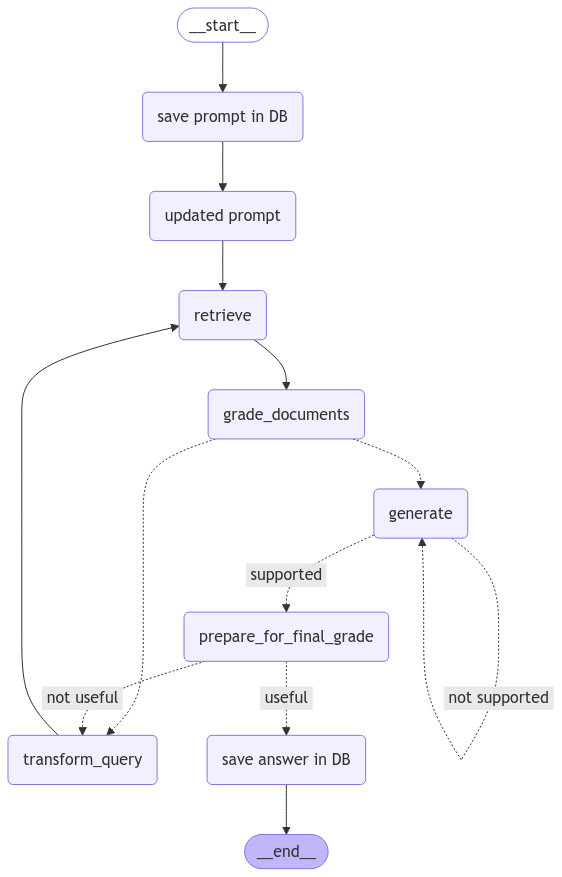

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# визуализируем полученный граф
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
inputs = {"keys": {"session_id": "Test5", "question": "Этот банк еще работает или закрылся?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---SAVING IN DB---
"Node 'save prompt in DB':"
'\n---\n'
---UPDATING PROMPT---
Invoke Result: {'answer': 'Рокетбанк был закрыт в 2018 году после слияния с Тинькофф Банком, и его услуги были интегрированы в платформу Тинькофф. Если вас интересует текущее состояние банковских продуктов или какие-то конкретные аспекты, связанные с этим процессом, я могу предоставить дополнительную информацию.'}
"Node 'updated prompt':"
'\n---\n'
---RETRIEVE---
5
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
0): «Рокетбанк» закрылся окончательно
«Рокетбанк» опубликовал на своей странице ВК прощальное сообщение, в котором подводит итоги своей восьмилетней деятельности и окончательно прощается с клиентами: «Всё началось в 2013-м с идеи сделать банк с человеческим лицом. А дальше вы знаете: служба поддержки, которая сразу полюбилась клиентам, удобное приложение с огромным количеством фич и уникальных продуктов, веб-банк, собственный мерч, разработка игр, самые живые соцсети во всём интернете и самые пред